In [1]:
import mdp
import pickle

In [2]:
# ! python mdp.py < ex.mdp
! python mdp.py < chaine_1.mdp

States: ['S0', 'S1', 'S2', 'S3', 'S4']
Actions: ['None']
Transition from S0 with no action and targets ['S1', 'S2'] with weights [5, 5]
Transition from S1 with no action and targets ['S0', 'S3'] with weights [5, 5]
Transition from S3 with no action and targets ['S3'] with weights [10]
Transition from S2 with no action and targets ['S4'] with weights [10]
Transition from S4 with no action and targets ['S4'] with weights [10]
{'States': ['S0', 'S1', 'S2', 'S3', 'S4'], 'Actions': ['None'], 'Transitions_with_action': {}, 'Transitions_without_action': {0: {'from': 'S0', 'targets': ['S1', 'S2'], 'weights': [5, 5]}, 1: {'from': 'S1', 'targets': ['S0', 'S3'], 'weights': [5, 5]}, 2: {'from': 'S3', 'targets': ['S3'], 'weights': [10]}, 3: {'from': 'S2', 'targets': ['S4'], 'weights': [10]}, 4: {'from': 'S4', 'targets': ['S4'], 'weights': [10]}}}


In [3]:
# On lit le .pickle des données que l'on souhaitent récupérer

# Read list to memory
def read_list(nom_liste):
    # for reading also binary mode is important
    with open(nom_liste, 'rb') as fp:
        liste = pickle.load(fp)
        return liste

L = read_list("liste_donnees")
print('Données récupérées', L)

Données récupérées {'States': ['S0', 'S1', 'S2', 'S3', 'S4'], 'Actions': ['None'], 'Transitions_with_action': {}, 'Transitions_without_action': {0: {'from': 'S0', 'targets': ['S1', 'S2'], 'weights': [5, 5]}, 1: {'from': 'S1', 'targets': ['S0', 'S3'], 'weights': [5, 5]}, 2: {'from': 'S3', 'targets': ['S3'], 'weights': [10]}, 3: {'from': 'S2', 'targets': ['S4'], 'weights': [10]}, 4: {'from': 'S4', 'targets': ['S4'], 'weights': [10]}}}


In [4]:
print('States:', L['States'])
print('Actions:', L['Actions'])
for transitions in L['Transitions_with_action']:
    print('Transition with action' ':', L['Transitions_with_action'][transitions])
for transitions in L['Transitions_without_action']:
    print('Transition without action' ':', L['Transitions_without_action'][transitions])

States: ['S0', 'S1', 'S2', 'S3', 'S4']
Actions: ['None']
Transition without action: {'from': 'S0', 'targets': ['S1', 'S2'], 'weights': [5, 5]}
Transition without action: {'from': 'S1', 'targets': ['S0', 'S3'], 'weights': [5, 5]}
Transition without action: {'from': 'S3', 'targets': ['S3'], 'weights': [10]}
Transition without action: {'from': 'S2', 'targets': ['S4'], 'weights': [10]}
Transition without action: {'from': 'S4', 'targets': ['S4'], 'weights': [10]}


> Pour la structure de données, peut-être faire un dictionnaire de matrices de transition, chaque clé correspondant à une action.

In [5]:
import numpy as np
import random

class States():
    def __init__(self, state, id,transitions_with_action, transitions_without_action):
        """
        Initialisation des états de la chaine de markov
        
        Args
        ----
        state : str
            Nom de l'état (S0...)
        id : int
            Numéro de l'état
        transitions_with_action : dict
            Dictionnaire de l'ensemble des transitions avec action
        transitions_without_action : dict
            Dictionnaire de l'ensemble des transitions sans action
        """
        self.state = state
        self.id = id
        self.transitions_without_action = {}
        self.transitions_with_action = {}
        for transition in transitions_without_action:
            # on parcours l'ensemble des transitions
            transi_active = transitions_without_action[transition]
            if transi_active["from"]==self.state: # on vérifie si l'état de départ est l'état actif
                # on ajoute les transitions sans action dans le dictionnaire en mettant les états cibles et leurs poids
                if transitions_without_action == {}:
                    self.transitions_without_action = {"targets" : transi_active["targets"], "weights" : transi_active["weights"]}
                else:
                    self.transitions_without_action["targets"] = transi_active["targets"]
                    self.transitions_without_action["weights"] = transi_active["weights"]

        for transition in transitions_with_action:
            transi_active = transitions_with_action[transition]
            if transi_active["from"]==self.state:
                # les clés dans transition_with_action sont les actions et les valeurs des dict des états cibles et leurs poids
                self.transitions_with_action[transi_active["action"]] = {"targets" : transi_active["targets"], "weights" : transi_active["weights"]}

    def __repr__(self):
        return (f"State : {self.state} \n State id {self.id} \n Transitions without action : {self.transitions_without_action} \n Transitions with action : {self.transitions_with_action}")


class markov():
    def __init__(self, states, actions, transitions_with_action, transitions_without_action):
        """
        Initialisation de la chaine de markov

        Args
        ----
        states : list
            Liste des états de la chaine
        actions : list
            Liste des actions possibles
        transitions_with_action : dict
            Dictionnaire de l'ensemble des transitions avec action
        transitions_without_action : dict
            Dictionnaire de l'ensemble des transitions sans action
        """
        self.states = {}
        self.actions = actions

        for state in states:
            self.states[f"{state}"] = States(state, states.index(state), transitions_with_action, transitions_without_action)

    def parcours(self,N, without_action = True, with_action = False): # on parcours la chaine (en faisant N étapes)
        """ 
        On parcours la chaine en faisant N étapes
        
        Args
        ----
        N : int
            Nombre d'étapes
        without_action : bool
            Si on fait des transitions sans action
        with_action : bool
            Si on fait des transitions en prenant en compte celels avec action
        """
        etat_actif = self.states["S0"]

        if without_action:
            for i in range(N):
                print(etat_actif.state) # on affiche l'état en cours
                poids = etat_actif.transitions_without_action["weights"]
                poids_total = np.sum(poids)
                poids = poids/poids_total # on normalise les poids pour qu'ils soient entre 0 et 1
                poids = np.cumsum(poids) # on fait la somme cumulée des poids, afin de pouvoir faire un tirage aléatoire (il ne faut pas que par exemple les deux probas soient de 0.5, il en faut une de 0.5 et l'autre de 1)

                choix = random.random() # tirage aléatoire entre 0 et 1

                for j in range(len(poids)): # on recherche l'état cible
                    if choix <= poids[j]:
                        etat_actif = self.states[etat_actif.transitions_without_action["targets"][j]]
                        break

    def __repr__(self):
        return (f"States : {self.states} \n Actions : {self.actions}")

In [8]:
# States(L['States'][1], 0, L['Transitions_with_action'], L['Transitions_without_action'])

M = markov(L['States'], L['Actions'], L['Transitions_with_action'], L['Transitions_without_action'])

M.parcours(10)


S0
S1
S0
S2
S4
S4
S4
S4
S4
S4


In [98]:
import graphviz

dot = graphviz.Digraph(comment='Processus de Décision Markoviens')

for i, state in enumerate(L['States']):
    dot.node(str(i), state)

dot.edges(['02','12'])
dot.edge('0', '1', label='test')

Utiliser la bibliothèque graphviz pour l'affichage. 
Quelques liens utiles :

Les attributs possibles pour les différentes fonctions : https://www.graphviz.org/doc/info/attrs.html

Doc graphviz : https://graphviz.readthedocs.io/en/stable/manual.html

In [99]:
print(dot.source)

// Processus de Décision Markoviens
digraph {
	0 [label=S0]
	1 [label=S1]
	2 [label=S2]
	0 -> 2
	1 -> 2
	0 -> 1 [label=test]
}



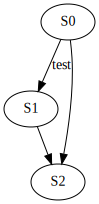

In [100]:
dot